[Link to Colab](https://drive.google.com/file/d/1rA74if483zHqc1BcjJr2sO38hplTlEE0/view?usp=sharing)


**Objective**:  
AdEase, an AI-driven advertising platform, aims to optimize ad placements for clients by leveraging historical Wikipedia page view data to forecast future views and enhance ad performance. The goal is to analyze daily view counts for 145,000 Wikipedia pages over 550 days and predict future page views to enable cost-effective and targeted ad placements. The solution must account for clients from diverse regions, requiring insights into page view trends across different languages to maximize clicks at minimal cost.

**Data Description**:  
- **Dataset**: Historical daily view counts for 145,000 Wikipedia pages spanning 550 days.
- **Features**:
  - Page identifier (e.g., page title or URL).
  - Language of the page (to support region-specific analysis).
  - Daily view counts for each page over 550 days.
- **Challenges**:
  - High dimensionality due to the large number of pages and time series data.
  - Variability in view patterns across pages, topics, and languages.
  - Need for scalable forecasting models to predict views accurately.
  - Requirement to segment insights by language to cater to regional clients.

**Tasks**:  
1. **Exploratory Data Analysis (EDA)**:  
   - Understand trends, seasonality, and anomalies in page view data.
   - Identify differences in view patterns across languages and page categories.
   - Assess data quality (e.g., missing values, outliers).

2. **Feature Engineering**:  
   - Extract relevant features, such as temporal patterns (day of week, month), page metadata (language, topic), and aggregated statistics (mean views, volatility).
   - Create language-specific features to support regional analysis.

3. **Forecasting Model Development**:  
   - Build time series forecasting models to predict future daily page views for each page.
   - Explore models like ARIMA, Prophet, or deep learning-based approaches (e.g., LSTM) for scalability and accuracy.
   - Evaluate model performance using metrics like MAE, RMSE, or MAPE.

4. **Ad Optimization Insights**:  
   - Segment pages by language and predicted view counts to recommend high-traffic pages for ad placements.
   - Provide region-specific recommendations to align with client needs.
   - Optimize ad placements to maximize clicks while minimizing costs, leveraging forecasted view trends.

**Expected Outcomes**:  
- Accurate forecasts of daily page views for Wikipedia pages, segmented by language.
- Actionable insights for ad placement strategies tailored to regional clients.
- A scalable pipeline for processing large-scale page view data and generating predictions.
- Enhanced ad performance through data-driven optimization, aligning with AdEase's mission of delivering effective and economical advertising solutions.

**Business Impact**:  
By forecasting Wikipedia page views and optimizing ad placements, AdEase can help clients achieve higher click-through rates at lower costs, strengthening its value proposition as an end-to-end digital advertising solution powered by the Design, Dispense, and Decipher AI modules.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TUNE=False

import re

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)


from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv('train_1.csv')

print('*************************************************')
print(df.info())
print('*************************************************\n')
print('*************************************************')
print(f'Shape of the dataset is {df.shape}')
print('*************************************************\n')
print('*************************************************')
print(f'Number of nan/null values in each column: \n{df.isna().sum()}')
print('*************************************************\n')
print('*************************************************')
print(f'Number of unique values in each column: \n{df.nunique()}')
print('*************************************************\n')
print('*************************************************')
print(f'Duplicate entries: \n{df.duplicated().value_counts()}')

*************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
None
*************************************************

*************************************************
Shape of the dataset is (145063, 551)
*************************************************

*************************************************
Number of nan/null values in each column: 
Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64
*************************************************

*************************************************
Number of unique values in each column: 
Page          145063
2015-07-01      6898
2015-07-02      6823
2015-07-03      6707
2015-07-04     

In [ ]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
df.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,1.247210e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
mean,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,1.189651e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,7.214536e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,1.130000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,5.450000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [ ]:
df.describe(include='object')

,Page
count,145063
unique,145063
top,Francisco_el_matemático_(serie_de_televisión_d...
freq,1


### Insight
- There are **145063** entries with 551 columns, i.e. 145063 wikipedia pages with views for 550 days
- There are null/missing values in each of the dates
- There are no **duplicates**
- There are **145063** unique wikipedia pages

In [ ]:
exog_en = pd.read_csv('Exog_Campaign_eng')

print('*************************************************')
print(exog_en.info())
print('*************************************************\n')
print('*************************************************')
print(f'Shape of the dataset is {exog_en.shape}')
print('*************************************************\n')
print('*************************************************')
print(f'Number of nan/null values in each column: \n{exog_en.isna().sum()}')
print('*************************************************\n')
print('*************************************************')
print(f'Number of unique values in each column: \n{exog_en.nunique()}')
print('*************************************************\n')
print('*************************************************')
print(f'Duplicate entries: \n{exog_en.duplicated().value_counts()}')

*************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB
None
*************************************************

*************************************************
Shape of the dataset is (550, 1)
*************************************************

*************************************************
Number of nan/null values in each column: 
Exog    0
dtype: int64
*************************************************

*************************************************
Number of unique values in each column: 
Exog    2
dtype: int64
*************************************************

*************************************************
Duplicate entries: 
True     548
False      2
Name: count, dtype: int64


In [ ]:
exog_en.head()

,Exog
0,0
1,0
2,0
3,0
4,0


### Insight
- There are **550** entries corresponding to 550 days in the previous dataset
- There are **no** null/missing values
- There are **2** unique values - 1 ans 0

# Exploratory Data Analysis

## Analysing date columns

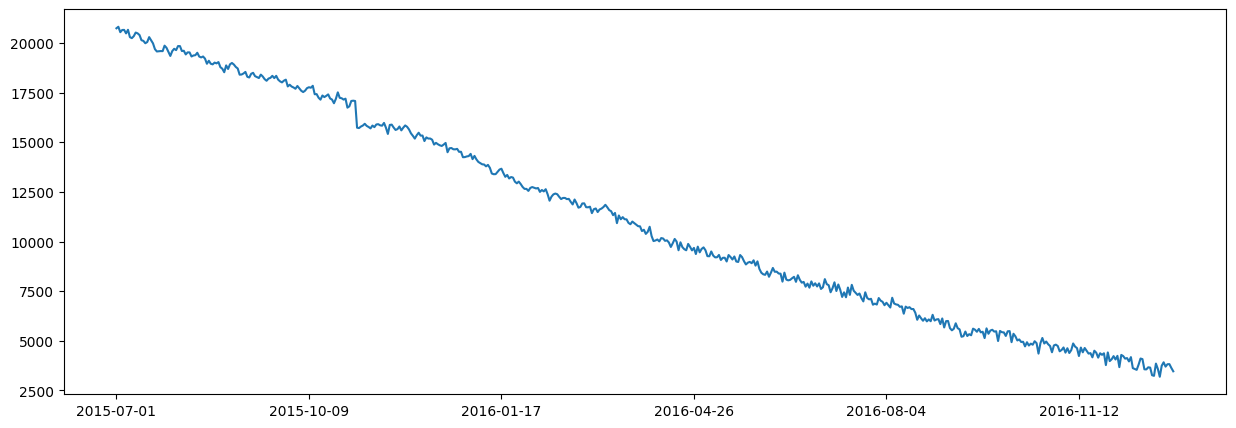

In [ ]:
date_columns = df.columns[1:]
df[date_columns].isna().sum().plot(figsize=(15,5))
plt.show()

### Insight
- It can be observed that the null values keep decreasing with dates, indicating that there were no views for these dates
- We can infer that the webpages which were lauched recently will not have view data prior to launch and hence can be filled with 0

In [ ]:
df[date_columns] = df.loc[:,date_columns].fillna(0)

In [ ]:
df.isna().sum()

,0
Page,0
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
...,...
2016-12-27,0
2016-12-28,0
2016-12-29,0
2016-12-30,0


## Extracting information from Page column

In [ ]:
df['Page'].sample(10)

,Page
61538,性在有情_zh.wikipedia.org_desktop_all-agents
80187,File:Europa-it-politica-coloured.svg_commons.w...
91623,Sorpasso_es.wikipedia.org_all-access_all-agents
85722,小林麻央_ja.wikipedia.org_desktop_all-agents
90139,特別:フィード項目/featured/20161023000000/ja_ja.wikipe...
143580,Realismo_literario_es.wikipedia.org_all-access...
16079,День_Военно-Морского_Флота_ru.wikipedia.org_mo...
26388,Platoon_fr.wikipedia.org_all-access_all-agents
124399,Пасхальное_приветствие_ru.wikipedia.org_all-ac...
131136,Équateur_(pays)_fr.wikipedia.org_all-access_sp...


The page name contains data in the below format: \
**SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN** \
having information about page name, thn domain, device type used to access t e
page, aso the request origin(spider or browser age
2.

### Extracting name

In [ ]:
def extract_name(page):
    pattern = r'(.{0,})_(.{2}).wikipedia.org_'
    result = re.findall(pattern, page)
    if len(result) == 1:
        return result[0][0]
    else:
        return 'unknown'
df['name'] = df['Page'].apply(extract_name)

<ipython-input-12-206822d5b8b3>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['name'] = df['Page'].apply(extract_name)


### Extracting language

In [ ]:
def extract_lang(page):
    pattern = r'(.{0,})_(.{2}).wikipedia.org_'
    result = re.findall(pattern, page)
    if len(result) == 1:
        return result[0][1]
    else:
        return 'un'
df['language'] = df['Page'].apply(extract_lang)
print(df['language'].unique())

['zh' 'fr' 'en' 'un' 'ru' 'de' 'ja' 'es']


<ipython-input-13-e92100694c85>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['language'] = df['Page'].apply(extract_lang)


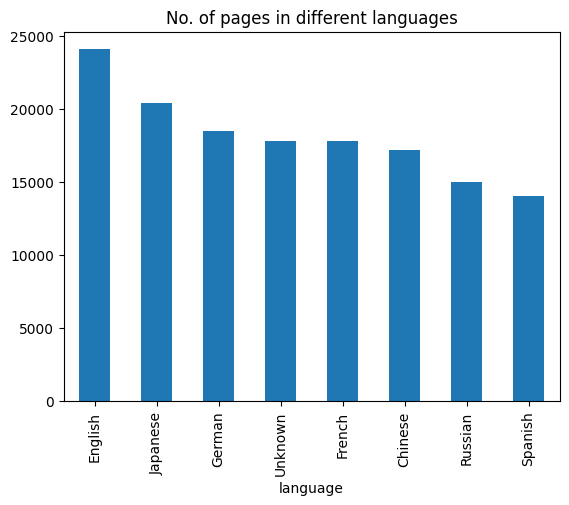

% of pages in different languages


,proportion
language,
English,16.62
Japanese,14.08
German,12.79
Unknown,12.31
French,12.27
Chinese,11.88
Russian,10.36
Spanish,9.70


In [ ]:
lang_name_mapping={'zh':'Chinese', 'fr':'French', 'en':'English',
                   'un':'Unknown', 'ru':'Russian', 'de':'German',
                   'ja':'Japanese', 'es':'Spanish'}
df['language'] = df['language'].map(lang_name_mapping)
df['language'].value_counts().plot(kind='bar', title='No. of pages in different languages')
plt.show()
print("% of pages in different languages")
round(df['language'].value_counts(normalize=True)*100,2)

### Insight
- Maximum number of pages, **16.62%**, are in **English** language

### Extracting access type

<ipython-input-15-e4ddf095414f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['access_type'] = df['Page'].str.findall(r'all-access|mobile-web|desktop').apply(lambda x: x[0])


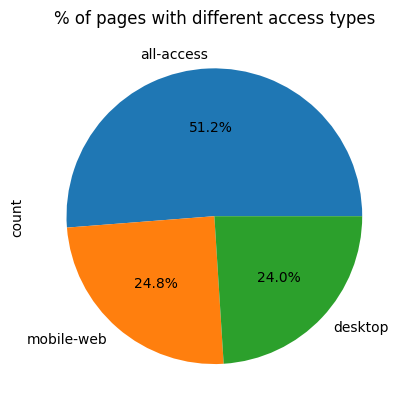

In [ ]:
df['access_type'] = df['Page'].str.findall(r'all-access|mobile-web|desktop').apply(lambda x: x[0])
df['access_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='% of pages with different access types')
plt.show()

### Insight
- Maximum number of pages, **51.2%**, have **all-access** access type

### Extracting access origin

<ipython-input-16-86c9e6feaf3c>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['access_origin'] = df['Page'].str.findall(r'spider|agents').apply(lambda x: x[0])


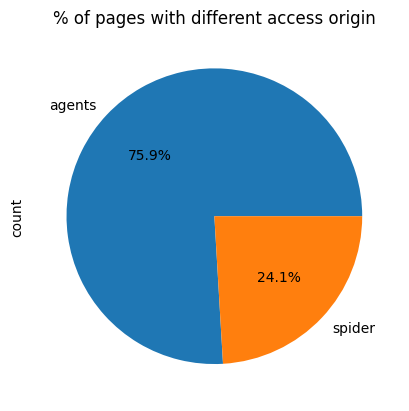

In [ ]:
df['access_origin'] = df['Page'].str.findall(r'spider|agents').apply(lambda x: x[0])
df['access_origin'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='% of pages with different access origin')
plt.show()

### Insight
- Maximum number of pages, **75.9%**, have **agents** access origin

# Aggregate and Pivoting

In [ ]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,name,language,access_type,access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,Chinese,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,Chinese,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,Chinese,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,Chinese,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,Chinese,all-access,spider


**Aggregating on language by taking average views per language for each date**

In [ ]:
df_agg = df.drop(columns=['Page', 'name', 'access_type', 'access_origin']).groupby('language').mean().T.reset_index()
df_agg['index'] = pd.to_datetime(df_agg['index'])
df_agg = df_agg.set_index('index')
df_agg.head()

language,Chinese,English,French,German,Japanese,Russian,Spanish,Unknown
index,,,,,,,,
2015-07-01,240.582042,3513.862203,475.150994,714.968405,580.647056,629.999601,1085.972919,83.479922
2015-07-02,240.941958,3502.511407,478.202000,705.229741,666.672801,640.902876,1037.814557,87.471857
2015-07-03,239.344071,3325.357889,459.837659,676.877231,602.289805,594.026295,954.412680,82.680538
2015-07-04,241.653491,3462.054256,491.508932,621.145145,756.509177,558.728132,896.050750,70.572557
2015-07-05,257.779674,3575.520035,482.557746,722.076185,725.720914,595.029157,974.508210,78.214562


## Time series plots for all languages

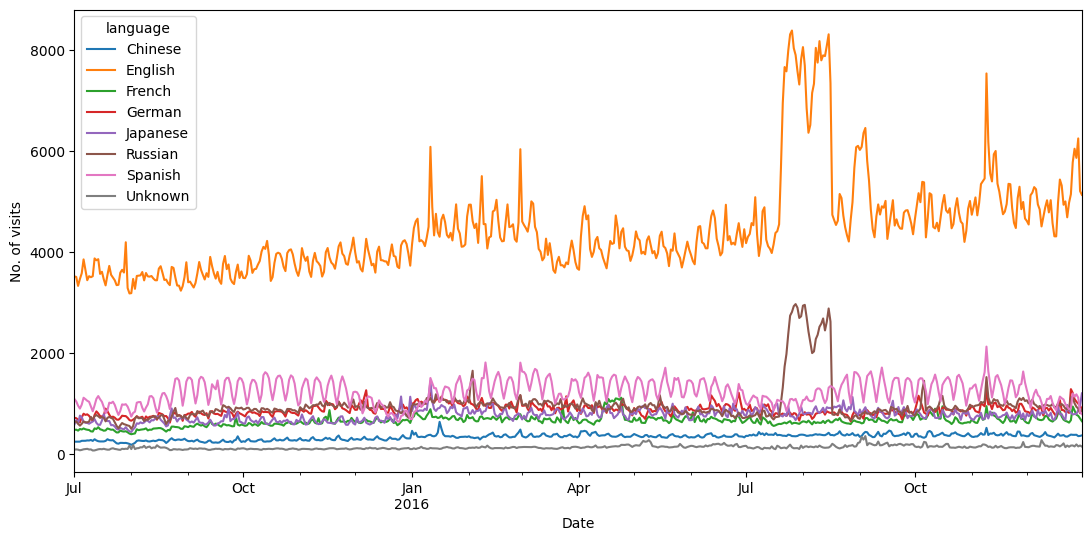

In [ ]:
df_agg.plot(figsize=(13,6))
plt.xlabel('Date')
plt.ylabel('No. of visits')
plt.show()

### Insight
- **English** pages are the **most visited** pages follwed by Spanish
- **English** pages have an **upward trend** in terms of visits
- There is an **unusual peak** from **mid of July to end of August 2016**

# Stationarity, Detrending, ACF and PACF

## Stationarity test

**Using Augmented Dickey-Fuller test to check for stationarity**
- H0: The series is not stationary
- H1: The series is stationary

In [ ]:
def adfuller_test(time_series):
    p_value = sm.tsa.stattools.adfuller(time_series)[1]
    if(p_value < 0.05):
        print('The time series is stationary')
    else:
        print('The time series is not stationary')

In [ ]:
for lang in df_agg.columns:
    print(lang)
    adfuller_test(df_agg[lang])
    print()

Chinese
The time series is not stationary

English
The time series is not stationary

French
The time series is not stationary

German
The time series is not stationary

Japanese
The time series is not stationary

Russian
The time series is stationary

Spanish
The time series is stationary

Unknown
The time series is stationary



### Insight
- Based on the Augmented Dickey-Fuller test, the time series corresponding to **Russian** and **Spanish** language page visits are **stationary**
- The time series corresponding to **Chinese, English, French, German** and **Japanese** language page visits are **not stationary**

**From now on, we will work only on the English language page visit time series**

In [ ]:
ts_english = df_agg['English']

**Let us look at the English time series along with its exog flag**

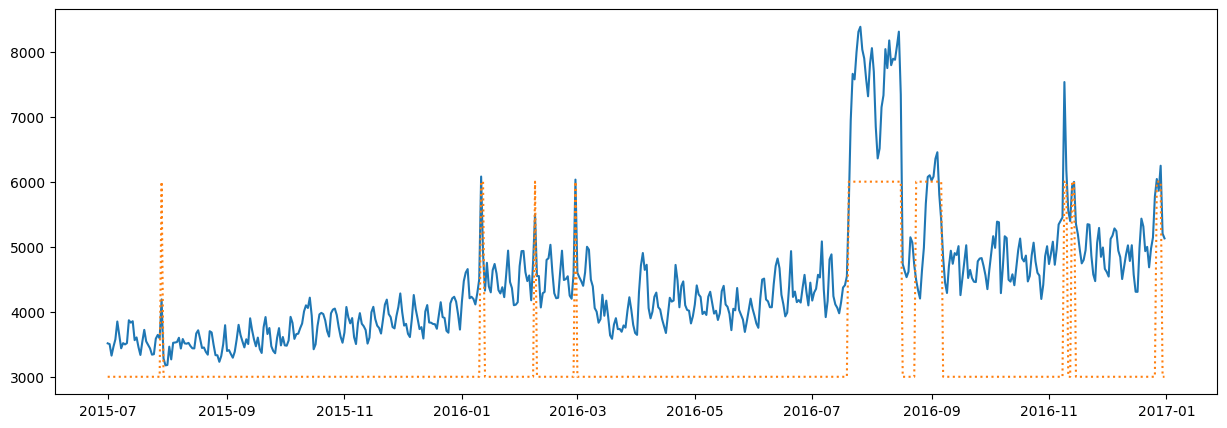

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ts_english.index, ts_english)
ax.plot(ts_english.index, (exog_en+1)*3000, ':')
plt.show()

### Insight
- It is very clear from the above plot that the time series looks like an additive time series with linear up trend and linear sesonality
- The unusual spikes in the visits are due to the special events marked by the orange peaks

## De-trending and De-seasoning

As the trend is linear, differencing with the previous value should de-trend the time series

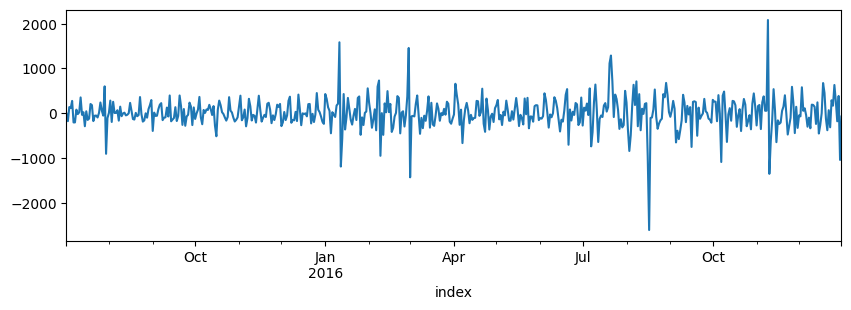

In [ ]:
ts_english.diff(1).dropna().plot(figsize=(10,3))
plt.show()

In [ ]:
adfuller_test(ts_english.diff(1).dropna())

The time series is stationary


The time series became stationary by just doing first-order differencing, hence **d=1**\
Let's now look at the seasonality

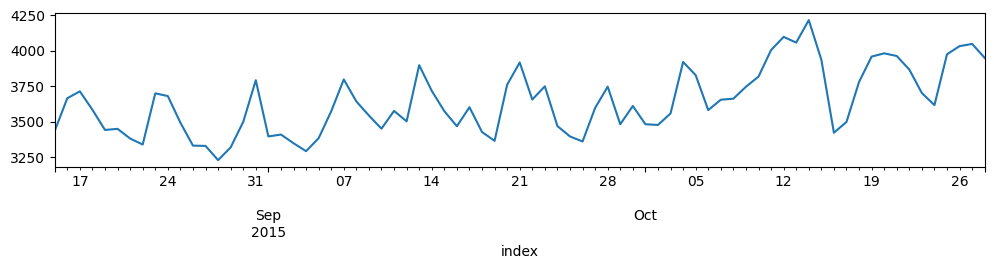

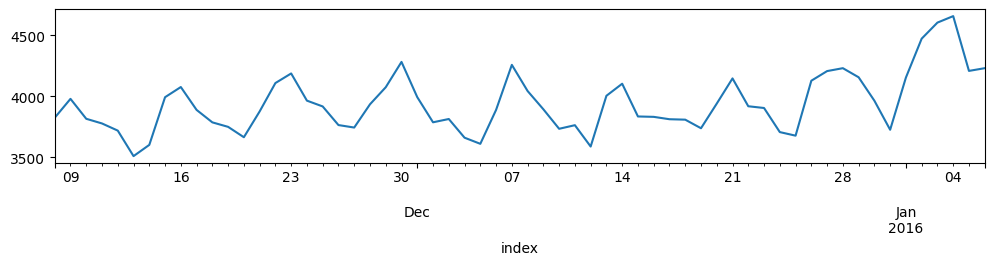

In [ ]:
ts_english[45:120].plot(figsize=(12,2))
plt.show()
ts_english[130:190].plot(figsize=(12,2))
plt.show()

- Observing the above two plots, we can conclude that there is a **seasonality** of **7 days**. So **s=7**
- The peaks and troughs repeat every 7 days

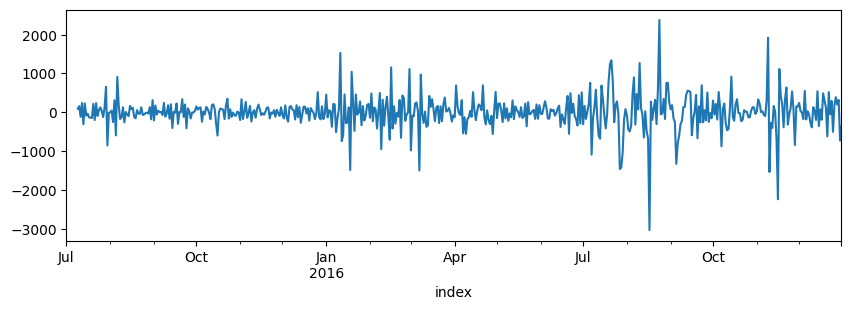

In [ ]:
ts_english.diff(1).diff(7).plot(figsize=(10,3))
plt.show()

In [ ]:
adfuller_test(ts_english.diff(1).diff(7).dropna())

The time series is stationary


After **removing** the **trend**(and if required, **seasonality**) manually, the Augmented Dickey-Fuller test says that the **time series is stationary**

## Auto de-composition
We had done manual decomposition above but there is a statsmodel library to decompose time series

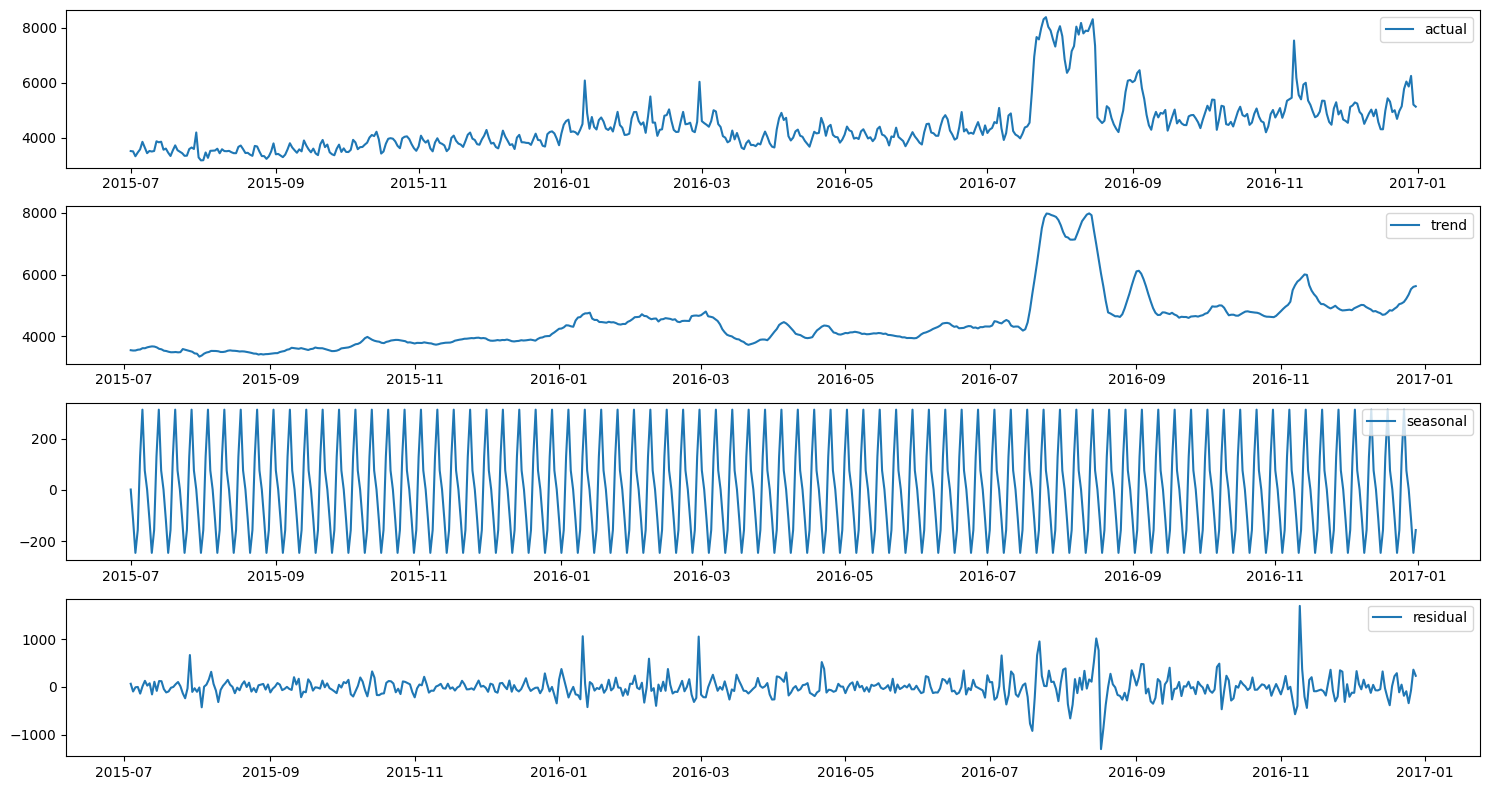

In [ ]:
decom = seasonal_decompose(ts_english)
ts_english_trend = decom.trend
ts_english_seas = decom.seasonal
ts_english_res = decom.resid
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(ts_english, label='actual')
plt.legend()
plt.subplot(412)
plt.plot(ts_english_trend, label='trend')
plt.legend()
plt.subplot(413)
plt.plot(ts_english_seas, label='seasonal')
plt.legend()
plt.subplot(414)
plt.plot(ts_english_res, label='residual')
plt.legend()
plt.tight_layout()
plt.show()

## ACF and PACF plots
- The ACF plot shows the correlation of a time series with itself at different lags, while the PACF plot shows the correlation of a time series with itself at different lags, after removing the effects of the previous lags
- The ACF plot can be used to identify the order of an AR model. The order of an AR model is the number of lags that are included in the model. The ACF plot will show spikes at the lags that are included in the model.
- The PACF plot can be used to identify the order of an MA model. The order of an MA model is the number of lags that are included in the model. The PACF plot will show spikes at the lags that are included in the model \
**Note**: Stationary data needs to be provided to the ACF and PACF plots

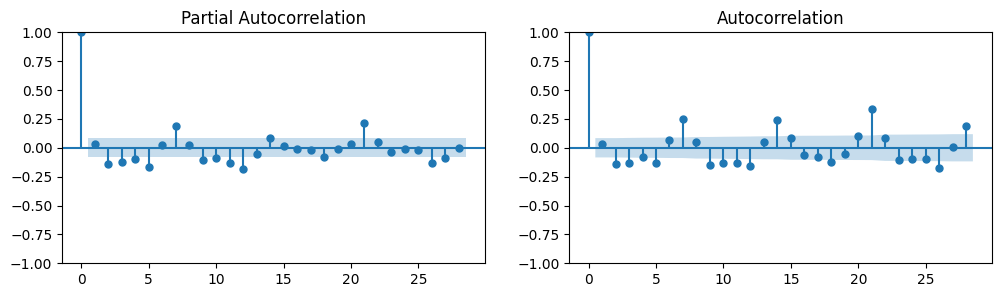

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 3))
plot_pacf(ax=axs[0], x=ts_english.diff(1).dropna())
plot_acf(ax=axs[1], x=ts_english.diff(1).dropna())
plt.show()

- From the PACF plot, we can see that there are 3 significant lags, at 5, 7 and 21. So **P=1,2 or 3**
- From the ACF plot, we can see that there are 3 significant lags, at 7, 14 and 21. So **Q=1,2 or 3**
- From the PACF plot, the cut-off is right from lag 0 and same for ACF plot. hence, **p** and **q =  0 or 1**

# Model building and Evaluation

In [ ]:
def performance(actual, predicted, print_metrics=True):
    MAE = round(mae(actual, predicted), 3)
    RMSE = round(mse(actual, predicted)**0.5, 3)
    MAPE = round(mape(actual, predicted), 3)
    if(print_metrics==True):
        print('MAE :', MAE)
        print('RMSE :', RMSE)
        print('MAPE:', MAPE)
    return MAE, RMSE, MAPE

## ARIMA model

In [ ]:
TS = ts_english.copy(deep=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


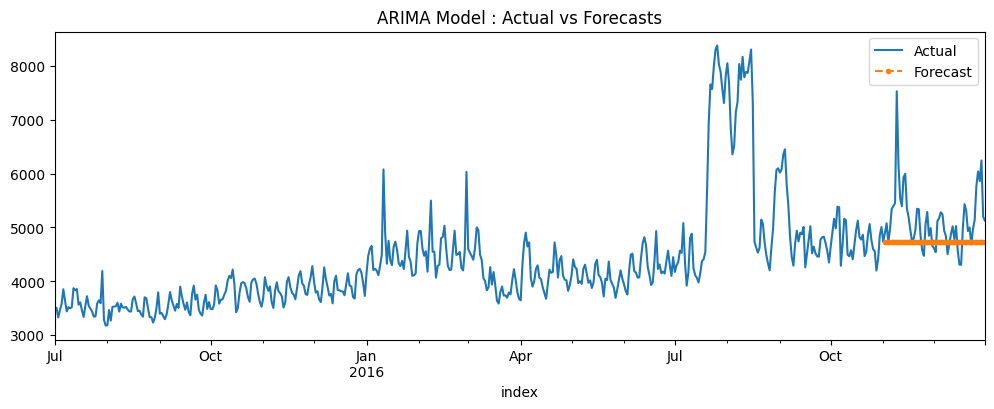

MAE : 477.636
RMSE : 672.778
MAPE: 0.086


In [ ]:
n_forecast = 60
model = ARIMA(TS[:-n_forecast], order = (0,1,0))
model = model.fit()
predicted = model.forecast(steps= n_forecast, alpha = 0.05)
plt.figure(figsize=(12,4))
TS.plot(label = 'Actual')
predicted.plot(label = 'Forecast', linestyle='dashed', marker='.')
plt.legend(loc="upper right")
plt.title('ARIMA Model : Actual vs Forecasts')
plt.show()
(_,_,_) = performance(TS.values[-n_forecast:], predicted.values, print_metrics=True)

### Insight
- The model is not doing a good job, even for different combinations of p and q

## SARIMAX model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


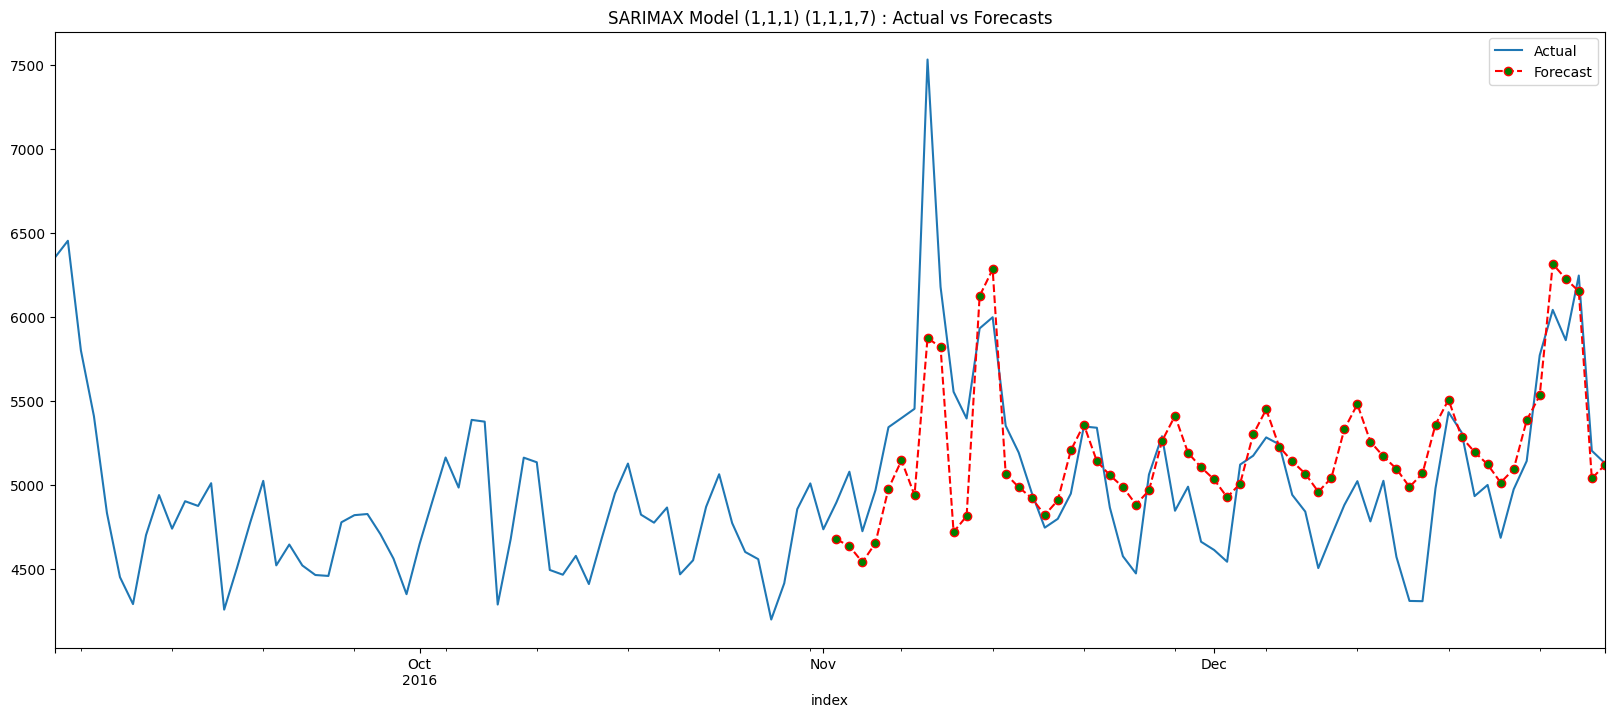

MAE : 306.417
RMSE : 399.016
MAPE: 0.06


In [ ]:
exog = exog_en['Exog'].to_numpy()
p,d,q,P,D,Q,s = 1,1,1,1,1,1,7
n_forecast = 60
model = SARIMAX(TS[:-n_forecast], order =(p,d,q), seasonal_order=(P, D, Q, s), exog = exog[:-n_forecast], initialization='approximate_diffuse')
model_fit = model.fit()
#Creating forecast for last n-values
model_forecast = model_fit.forecast(n_forecast, dynamic = True, exog = pd.DataFrame(exog[-n_forecast:]))

plt.figure(figsize = (20,8))
TS[-120:].plot(label = 'Actual')
model_forecast[-120:].plot(label = 'Forecast', color = 'red', linestyle='dashed', marker='o',markerfacecolor='green')
plt.legend(loc="upper right")
plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts')
plt.show()

(_,_,_) = performance(TS.values[-n_forecast:], model_forecast.values, print_metrics=True)

### Insight
- SARIMAX model is doing a significantly better job. We need to search for the right order values

In [ ]:
def SARIMAX_search(TS, forecast, p_list, d_list, q_list, P_list, D_list, Q_list, s_list, exog=[]):
    counter = 0
    #perf_df = pd.DataFrame(columns=['serial', 'pdq', 'PDQs', 'mape', 'rmse', 'aic', 'bic'])
    perf_df = pd.DataFrame(columns=['serial', 'pdq', 'PDQs', 'mape', 'rmse'])

    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            for s in s_list:
                                try:
                                    model = SARIMAX(TS[:-n_forecast], order =(p,d,q), seasonal_order=(P, D, Q, s), exog = exog[:-n_forecast], initialization='approximate_diffuse')
                                    model_fit = model.fit()
                                    model_forecast = model_fit.forecast(n_forecast, dynamic = True, exog = pd.DataFrame(exog[-n_forecast:]))
                                    MAE, RMSE, MAPE = performance(TS.values[-n_forecast:], model_forecast.values, print_metrics=False)
                                    counter += 1
                                    #list_row = [counter, (p,d,q), (P,D,Q,s), MAPE, RMSE, model_fit.aic, model_fit.bic]
                                    list_row = [counter, (p,d,q), (P,D,Q,s), MAPE, RMSE]
                                    perf_df.loc[len(perf_df)] = list_row
                                    print(f'Combination {counter} out of {(len(p_list)*len(d_list)*len(q_list)*len(P_list)*len(D_list)*len(Q_list)*len(s_list))}')
                                except:
                                    continue
    return perf_df

In [ ]:
if TUNE:
    TS = ts_english.copy(deep=True)
    n_forecast = 60
    p_list = [0,1]
    d_list = [1]
    q_list = [0,1]
    P_list = [2,3]
    D_list = [1]
    Q_list = [2,3]
    s_list = [7]
    exog = exog_en['Exog'].to_numpy()
    perf_df = SARIMAX_search(TS, n_forecast, p_list, d_list, q_list, P_list, D_list, Q_list, s_list, exog)
    perf_df=perf_df.sort_values(['mape', 'rmse'])
    perf_df.head()

After the above experiment, p,d,q,P,D,Q,s = 1,1,1,2,1,3,7 were found to be best values with low mape

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


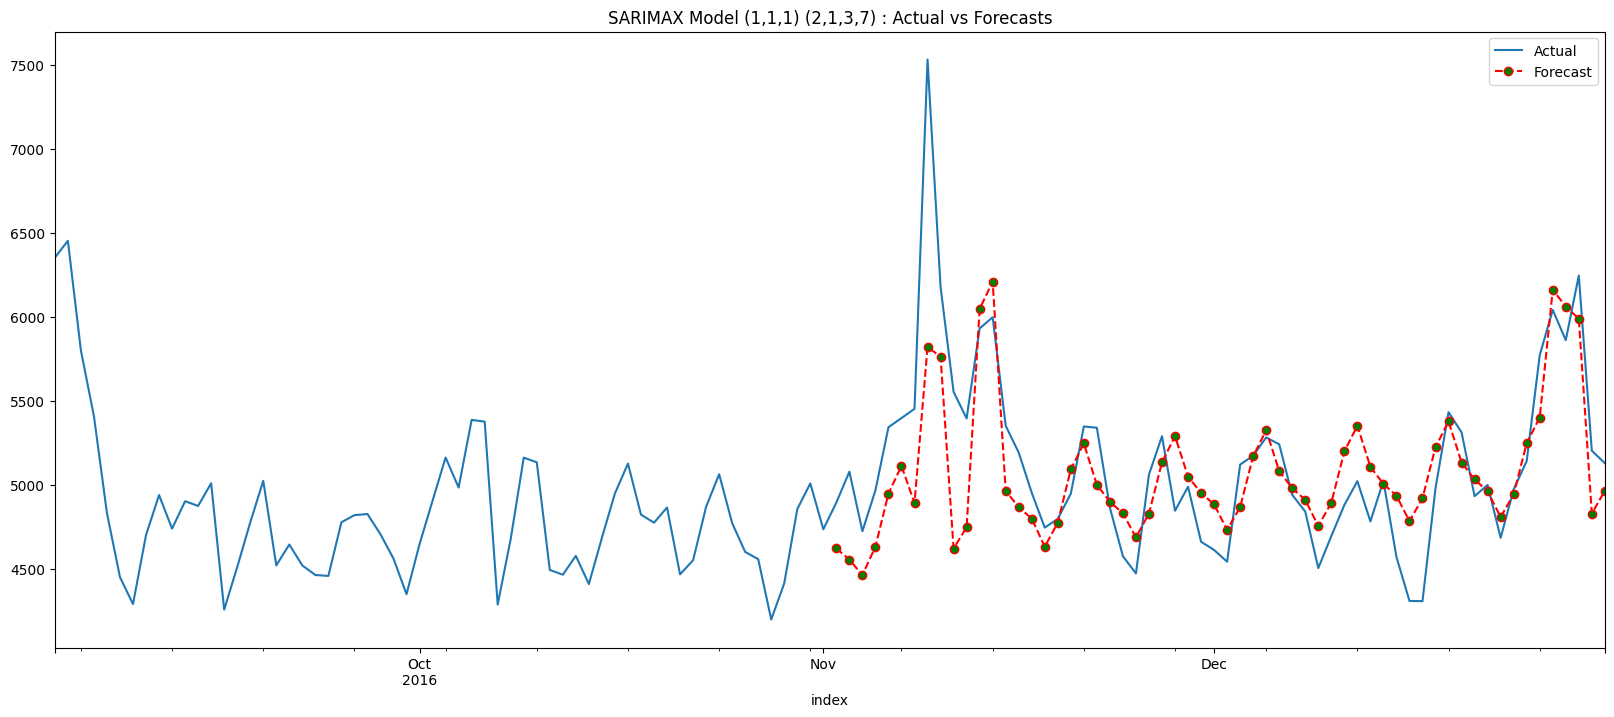

MAE : 270.513
RMSE : 373.484
MAPE: 0.051


In [ ]:
exog = exog_en['Exog'].to_numpy()
p,d,q,P,D,Q,s = 1,1,1,2,1,3,7
n_forecast = 60
model = SARIMAX(TS[:-n_forecast], order =(p,d,q), seasonal_order=(P, D, Q, s), exog = exog[:-n_forecast], initialization='approximate_diffuse')
model_fit = model.fit()
#Creating forecast for last n-values
model_forecast = model_fit.forecast(n_forecast, dynamic = True, exog = pd.DataFrame(exog[-n_forecast:]))

plt.figure(figsize = (20,8))
TS[-120:].plot(label = 'Actual')
model_forecast[-120:].plot(label = 'Forecast', color = 'red', linestyle='dashed', marker='o',markerfacecolor='green')
plt.legend(loc="upper right")
plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts')
plt.show()

(_,_,_) = performance(TS.values[-n_forecast:], model_forecast.values, print_metrics=True)

### Insight
- There is good improvement in the SARIMAX model after tuning the parameters

## Facebook Prophet

In [ ]:
TS = ts_english.copy(deep=True).reset_index()
TS = TS[['index', 'English']]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
exog = exog_en['Exog']
TS['exog'] = exog.values
TS.tail()

,ds,y,exog
545,2016-12-27,6040.680728,1
546,2016-12-28,5860.227559,1
547,2016-12-29,6245.127510,1
548,2016-12-30,5201.783018,0
549,2016-12-31,5127.916418,0


In [ ]:
#!pip install pystan~=2.14
#!pip uninstall prophet
#!pip install prophet --upgrade

In [ ]:
from prophet import Prophet
my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.add_regressor('exog')
n_forecast = 60
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
future_dates['exog'] = TS['exog']
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/txapa7q_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/2rk9ufdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75271', 'data', 'file=/tmp/tmpt8r8_cuj/txapa7q_.json', 'init=/tmp/tmpt8r8_cuj/2rk9ufdr.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_model679_503r/prophet_model-20250414071238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 287.417
RMSE : 441.959
MAPE: 0.06


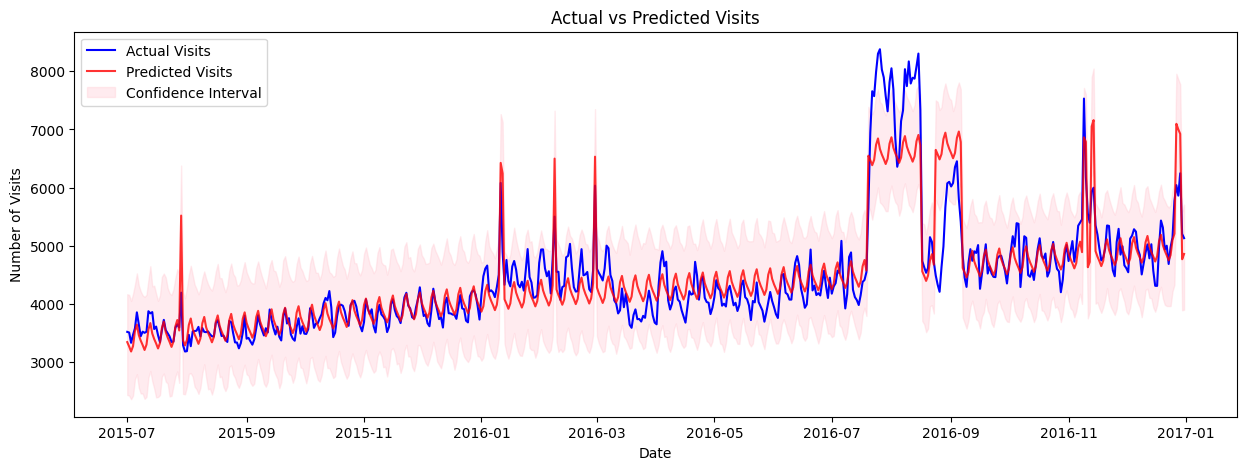

In [ ]:
# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

### Insight
- Phropet is doing an incredible job capturing the trend and unusual peaks. It is also capturing the seasonality very well

## Comparison

## Chinese

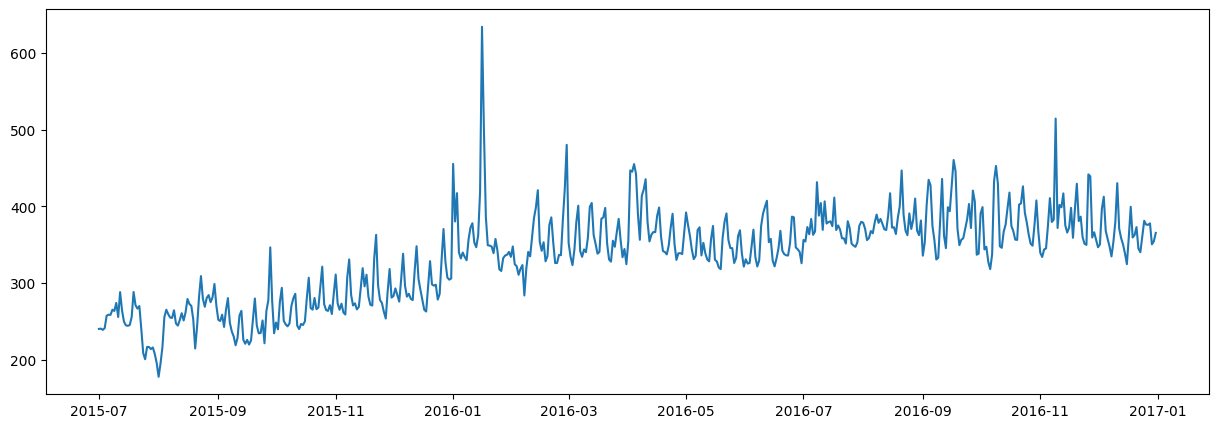

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/f_svanyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/z2aam0i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10738', 'data', 'file=/tmp/tmpt8r8_cuj/f_svanyo.json', 'init=/tmp/tmpt8r8_cuj/z2aam0i1.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_model2pbrc66w/prophet_model-20250414071239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 19.353
RMSE : 28.703
MAPE: 0.058


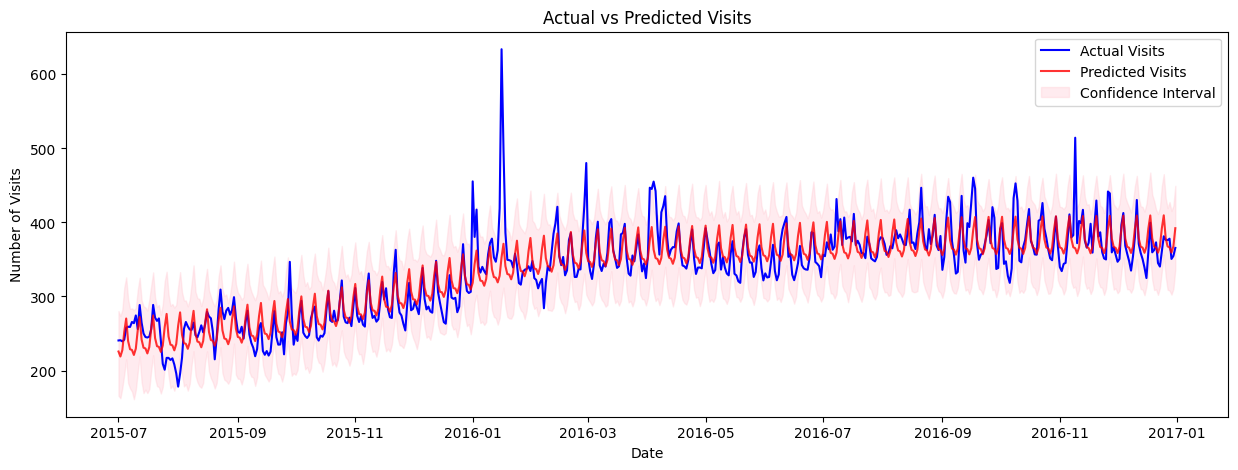

In [ ]:
lang = 'Chinese'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

## French

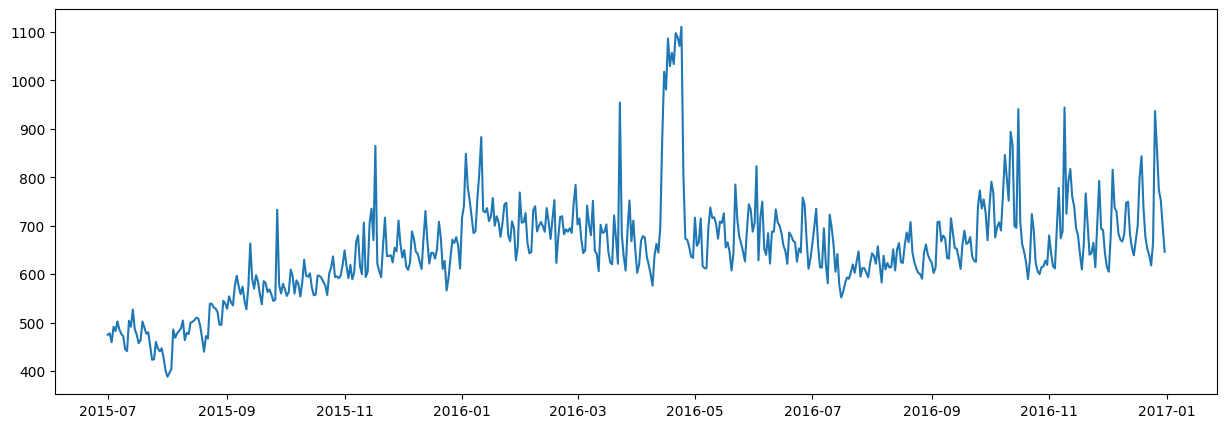

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/d9uyqlc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/4lcbjsum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48930', 'data', 'file=/tmp/tmpt8r8_cuj/d9uyqlc1.json', 'init=/tmp/tmpt8r8_cuj/4lcbjsum.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_modely7rfautg/prophet_model-20250414071241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 42.038
RMSE : 68.864
MAPE: 0.061


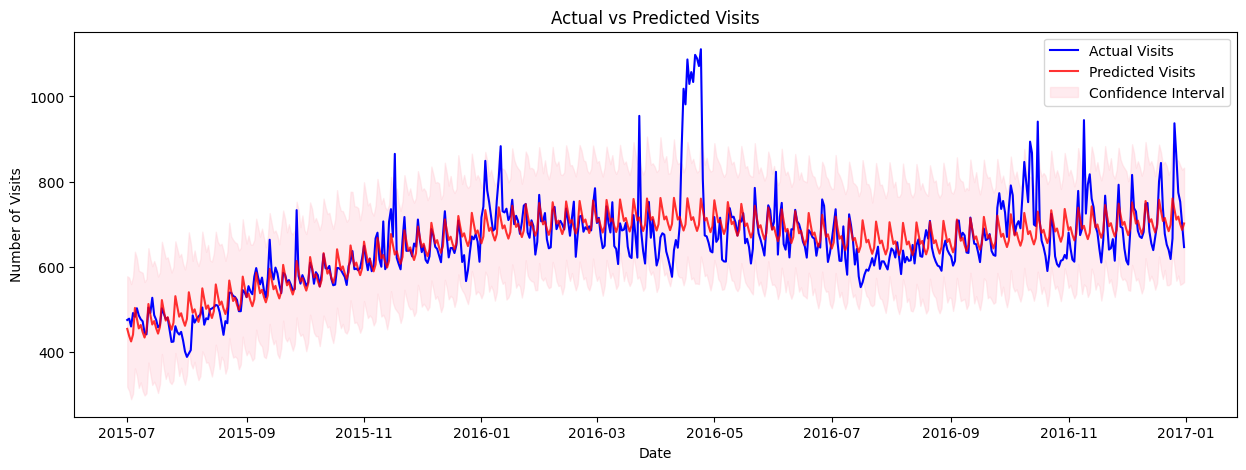

In [ ]:
lang = 'French'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

## German

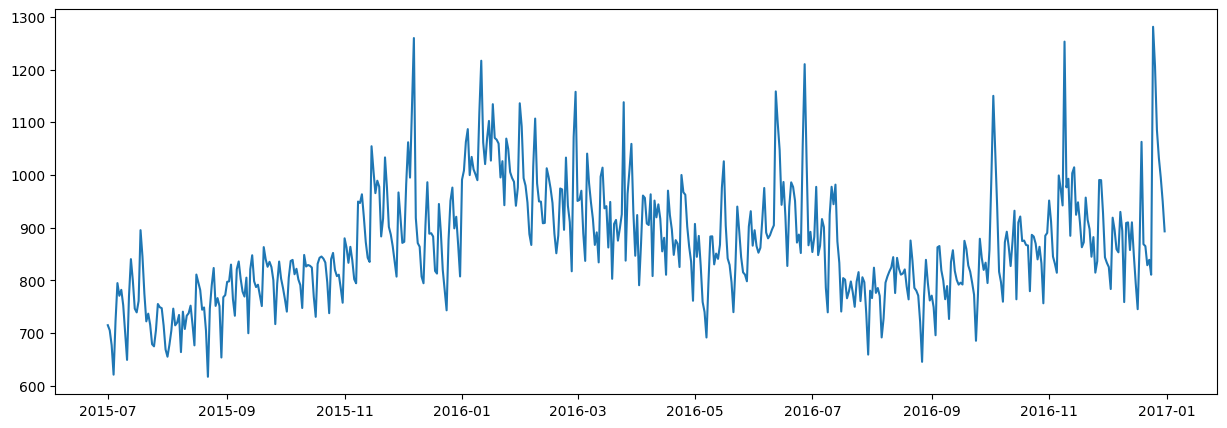

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/c8z4id_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/zdtip2nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52145', 'data', 'file=/tmp/tmpt8r8_cuj/c8z4id_c.json', 'init=/tmp/tmpt8r8_cuj/zdtip2nx.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_modelwzgvsf12/prophet_model-20250414071241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 49.262
RMSE : 68.189
MAPE: 0.055


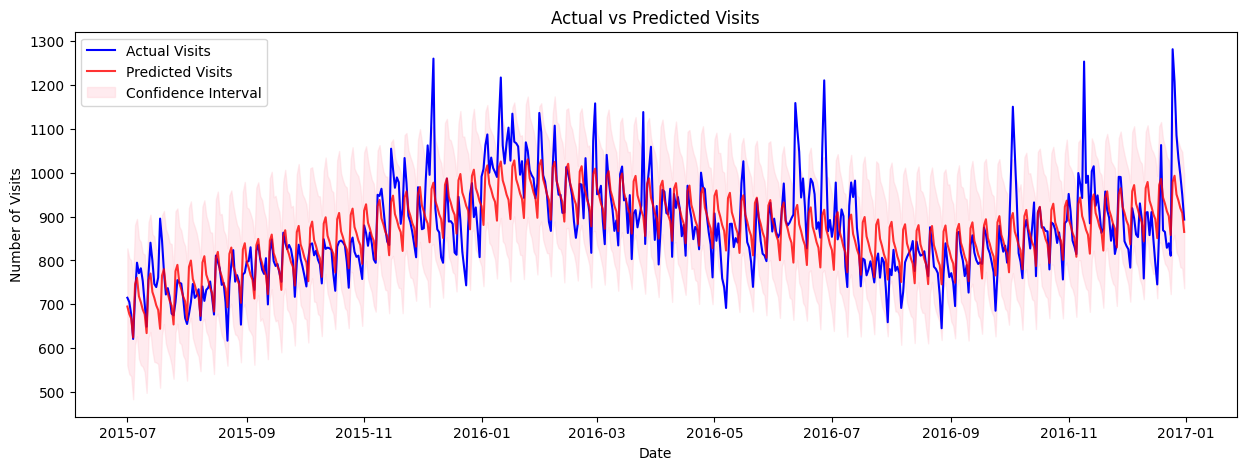

In [ ]:
lang = 'German'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

## Japanese

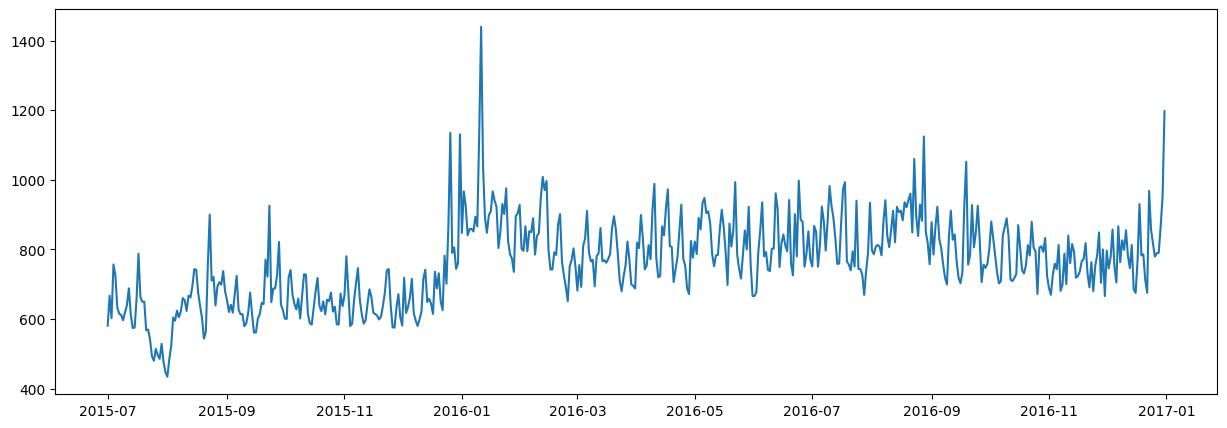

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/818tb_fz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/me0fcyf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89380', 'data', 'file=/tmp/tmpt8r8_cuj/818tb_fz.json', 'init=/tmp/tmpt8r8_cuj/me0fcyf2.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_modelepvhzzls/prophet_model-20250414071242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 61.153
RMSE : 84.062
MAPE: 0.08


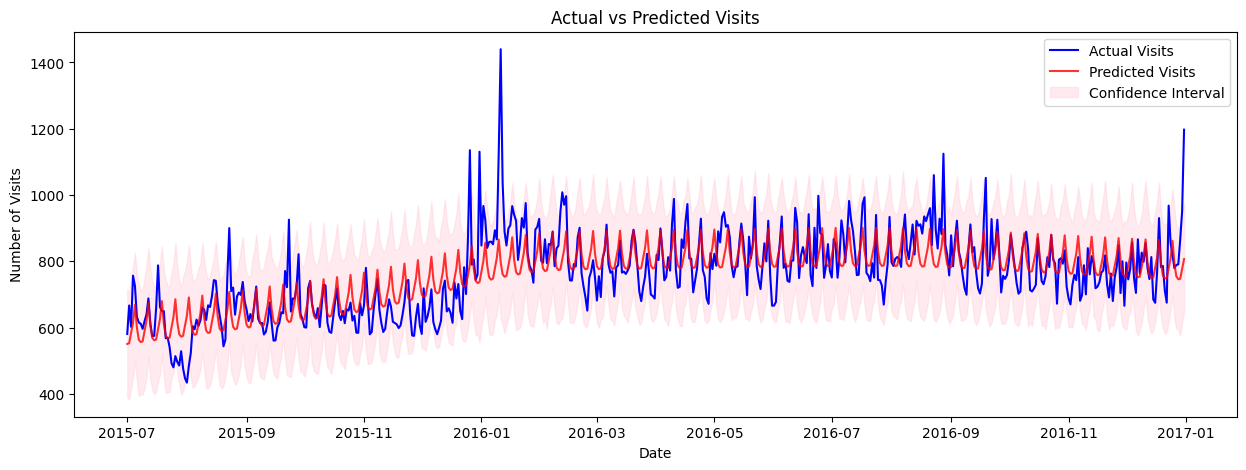

In [ ]:
lang = 'Japanese'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

## Russian

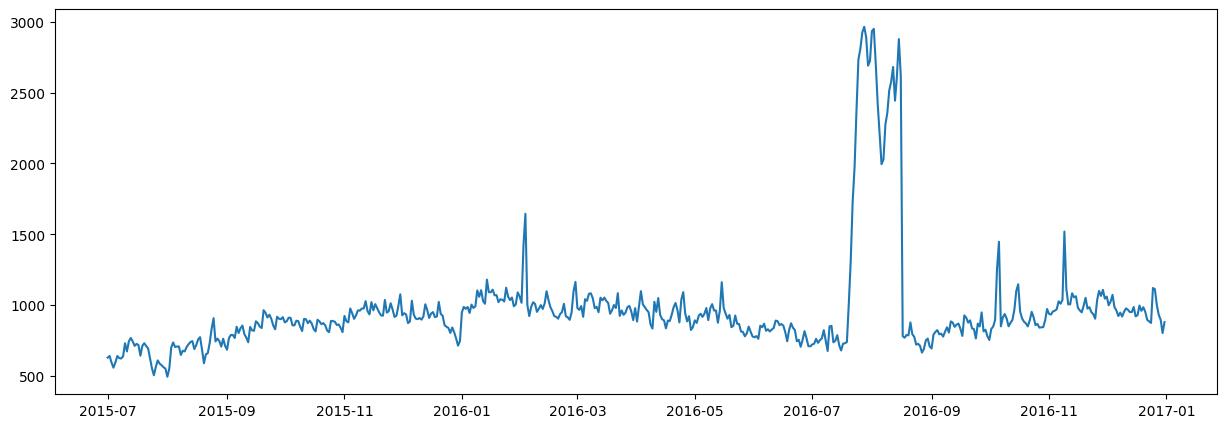

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/kl_fb303.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/46oeo5mp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58012', 'data', 'file=/tmp/tmpt8r8_cuj/kl_fb303.json', 'init=/tmp/tmpt8r8_cuj/46oeo5mp.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_modelt8ki73xt/prophet_model-20250414071243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 185.326
RMSE : 353.315
MAPE: 0.169


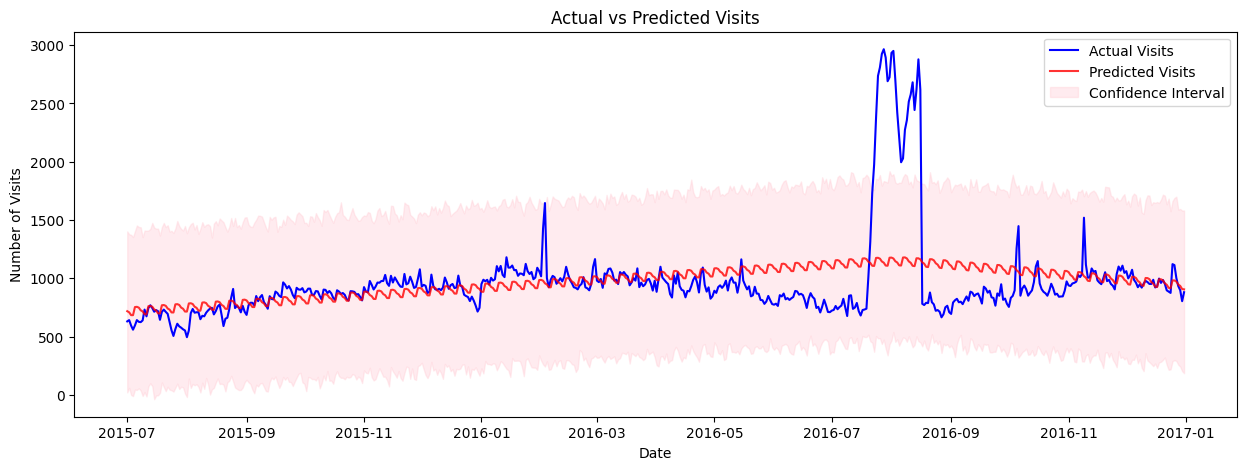

In [ ]:
lang = 'Russian'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

## Spanish

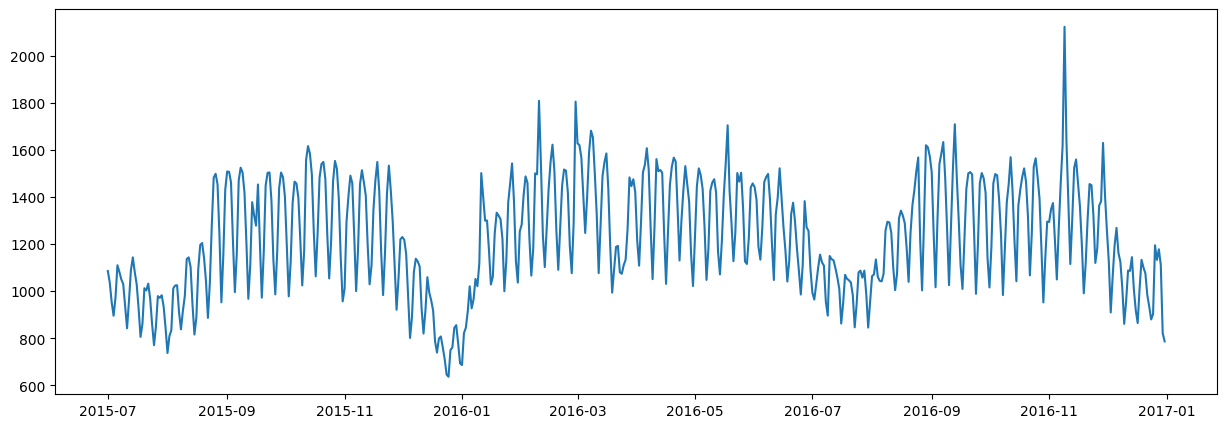

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/0juf5sik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt8r8_cuj/x4py9xoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51386', 'data', 'file=/tmp/tmpt8r8_cuj/0juf5sik.json', 'init=/tmp/tmpt8r8_cuj/x4py9xoi.json', 'output', 'file=/tmp/tmpt8r8_cuj/prophet_modelmmugxizi/prophet_model-20250414071243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 134.492
RMSE : 173.774
MAPE: 0.118


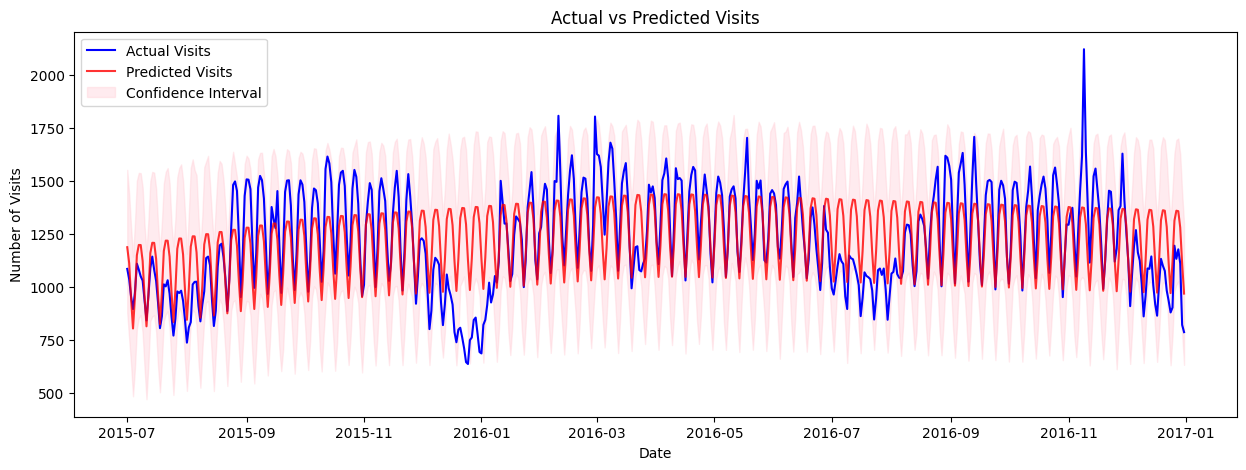

In [ ]:
lang = 'Spanish'
TS = df_agg[lang].copy(deep=True)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(TS.index, TS)
plt.show()

TS = TS.reset_index()
TS = TS[['index', lang]]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])
TS.tail()

my_model = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
my_model.fit(TS)
future_dates = my_model.make_future_dataframe(periods=0)
forecast = my_model.predict(future_dates)

# Step 6: Merge Predictions with Actual Data
TS['yhat'] = forecast['yhat']  # The predicted values (yhat) from Prophet
TS['yhat_upper'] = forecast['yhat_upper']  # Upper bound of the confidence interval
TS['yhat_lower'] = forecast['yhat_lower']  # Lower bound of the confidence interval

(_,_,_) = performance(TS['y'], TS['yhat'], print_metrics=True)

# Plot actual vs predicted visits
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['yhat'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(TS['ds'], TS['yhat_lower'], TS['yhat_upper'], color='pink', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

#Questionnaire




---

## **1. Defining the Problem Statement and Applications**

**Question**: Defining the problem statements and where can this and modifications of this be used?

**Answer**:  
The primary **problem statement** is to **optimize ad placements** for AdEase clients by **forecasting future Wikipedia page views** using historical data (**145,000 pages over 550 days**) and leveraging **language-specific trends** to **maximize clicks at minimal cost**. The solution involves:  
- Analyzing view patterns.  
- Building **scalable forecasting models**.  
- Providing **region-specific ad placement recommendations**.  

**Applications**:  
- **Digital advertising**: Target high-traffic pages for ad placements.  
- **E-commerce**: Plan inventory based on predicted traffic.  
- **Content platforms**: Personalize content delivery using traffic forecasts.  

**Modifications**:  
- Adapt the model for other platforms (e.g., **X posts**).  
- Incorporate **real-time data streams**.  
- Extend to industries like **news analytics** by adding features like **trending topics** or **event-driven data** and adjusting for **different seasonality patterns**.

---

## 2. Inferences from Data Visualizations

**Question**: Write 3 inferences you made from the data visualizations.

**Answer**:

- English pages dominate with **16.62%** of total pages, indicating higher content availability or interest compared to other languages like Japanese (14.08%) or Russian (10.36%).

- Agents access constitutes **75.9%** of page origins, suggesting most traffic comes from automated or programmatic sources rather than direct user visits.

- All-access pages account for **51.2%** of access types, reflecting a preference for open-access content over restricted or subscription-based models.

---

## **3. Purpose of Series Decomposition**

**Question**: What does the decomposition of series do?

**Answer**:  
**Decomposition** breaks down a time series into its components:  
- **Trend**: The long-term direction.  
- **Seasonality**: Repeating patterns at fixed intervals.  
- **Residual (Error)**: Random fluctuations.  
This helps in **understanding underlying patterns** and improving model accuracy.

---

## **4. Differencing for Stationarity**

**Question**: What level of differencing gave you a stationary series?

**Answer**:  
A **differencing level of 1** produced a **stationary series** for the **English language time series data**, as confirmed by the **Augmented Dickey-Fuller test**.

---

## **5. ARIMA vs. SARIMA vs. SARIMAX**

**Question**: Difference between ARIMA, SARIMA & SARIMAX.

**Answer**:  
- **ARIMA**: Models **non-seasonal time series** with trends and autocorrelations using **AutoRegressive (AR)**, **Integrated (I)**, and **Moving Average (MA)** components.  
- **SARIMA**: Extends ARIMA to handle **seasonality**, modeling both **non-seasonal** and **seasonal patterns** (e.g., monthly or yearly cycles).  
- **SARIMAX**: Extends SARIMA by including **exogenous variables** (external factors), enabling modeling of **seasonal**, **non-seasonal**, and **external influences** on the time series.

---

## **6. Comparing Views Across Languages**

**Question**: Compare the number of views in different languages.

**Answer**:  
Based on the provided chart:  
- **English**: Represents **16.62% of pages**, with the **highest views**, peaking **above 8,000**, reflecting dominant traffic due to widespread usage.  

- **Other languages** (Chinese, French, German, Japanese, Russian): Have **lower and stable views**, generally **below 2,000**, with minor peaks (e.g., **Russian around 2,000**).

---

## **7. Alternatives to Grid Search**

**Question**: What other methods other than grid search would be suitable to get the model for all languages?

**Answer**:  
- **Random Search**: Explores a **random subset of hyperparameters**, efficient for **large datasets** like this.  
- **Bayesian Optimization**: Uses **probabilistic models** to optimize hyperparameters, ideal for **complex models** across languages.  
- **Genetic Algorithms**: Evolves **model configurations** to find optimal parameters, effective for **diverse language patterns**.  
- **AutoML Tools** (e.g., Auto-sklearn, TPOT): **Automates model selection and tuning**, adapting to variability across languages without manual grid search.

---

## **8. Improving Predictions and Challenges Without Exogenous Variables**

**Question**: How can AdEase improve its predictions, and what challenges arise without exogenous variables?

**Answer**:  
**Improvements**:  
AdEase can use the **Prophet model** with **exogenous variables** to enhance predictions, as **events or campaigns** significantly impact performance (e.g., **English page views peak when the exogenous variable is 1**).  

**Challenges Without Exogenous Variables**:  
- **Inaccurate predictions**: Without exogenous variables, models fail to capture **event-driven spikes** or **external influences**, as seen in **other languages** lacking such data.  
- **Reduced model robustness**: Missing external factors limits the ability to explain **unusual patterns**, leading to unreliable forecasts.

---


In [57]:
#!sudo apt-get update
#!sudo apt-get install -y pandoc
#!sudo apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

#!pip install --upgrade nbconvert

#!jupyter nbconvert --to pdf AdEase_business_case.ipynb